### 2-D Branching Brownian Motion Simulation

In [1]:
import numpy as np
from statsmodels.tsa import stattools
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [10]:
class bbm(object):
    def __init__(self, xmin = -5, xmax = 5, ymin = -5, ymax = 5, itally = 20, nn = 20,
                 n = 1000, tf = 10, nsteps = 1000, D = 0.01, t = 0.0, lmbd = 1.0, bnd = 1):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.itally = itally
        self.nn = nn
        self.n = n
        self.tf = tf
        self.nsteps = nsteps
        self.D = D
        self.t = t
        self.lmbd = lmbd
        self.bnd = bnd
            
        self.hx = (self.xmax - self.xmin) / float(self.nn)
        self.hy = (self.ymax - self.ymin) / float(self.nn)
        self.A = (self.ymax - self.ymin)
        self.dt = self.tf / float(self.nsteps)
        self.sigma = np.sqrt(2 * self.D * self.dt)
        self.btimes = - np.log(np.random.random((self.n, 1))) / self.lmbd
        
    def bmstep(self, x):
        n, _ = x.shape
        dr = np.random.random((n, 2)) * self.sigma
        theta = np.arccos(np.random.random((n,)))
        dx = np.multiply(dr[:, 0], np.cos(theta))
        dy = np.multiply(dr[:, 1], np.sin(theta))
        xnew = x + np.vstack((dx, dy)).T
        
        if self.bnd == 1:
            # periodic boundaries
            xbr = (xnew[:, 0] > self.xmax).nonzero()
            xnew[xbr, 0] = self.xmin - self.xmax + xnew[xbr, 0]
            xbl = (xnew[:, 0] < self.xmin).nonzero()
            xnew[xbl, 0] = self.xmax - self.xmin + xnew[xbl, 0]
            xbu = (xnew[:, 1] > self.ymax).nonzero()
            xnew[xbu, 1] = self.ymin - self.ymax + xnew[xbu, 1]
            xbd = (xnew[:, 1] < self.ymin).nonzero()
            xnew[xbd, 1] = self.ymax - self.ymin + xnew[xbd, 1]
        elif self.bnd == 2:
            # reflective boundaries
            xbr = (xnew[:, 0] > self.xmax).nonzero()
            xnew[xbr, 0] = 2 * self.xmax + xnew[xbr, 0]
            xbl = (xnew[:, 0] < self.xmin).nonzero()
            xnew[xbl, 0] = 2 * self.xmin + xnew[xbl, 0]
            xbu = (xnew[:, 1] > self.ymax).nonzero()
            xnew[xbu, 1] = 2 * self.ymax + xnew[xbu, 1]
            xbd = (xnew[:, 1] < self.ymin).nonzero()
            xnew[xbd, 1] = 2 * self.ymin + xnew[xbd, 1]
            
        return xnew
    
    def branch(self, x):
        bdi = (self.t >= self.btimes).nonzero()[0]
        m = np.size(bdi)
        md = np.sum((np.random.random(m) > 0.5))
        mb = m - md
        
        di = bdi[0: md]
        bi = bdi[md: m]

        x[di,:] = self.btimes[di] = np.nan
        x = np.vstack((x, x[bi,:]))
        
        times = self.t - np.log(np.random.random(mb)) / self.lmbd
        times = times.reshape(len(times), 1)
        self.btimes = np.vstack((self.btimes, times))
        self.btimes[bi] = times

        x = x[~ np.all(np.isnan(x), axis = 1)]
        self.btimes = self.btimes[~ np.all(np.isnan(self.btimes), axis = 1)]

        return x, self.btimes
    
    def accum_tally(self, tally, x):
        k = (np.floor((x[:, 0] - self.xmin) / self.hx) + self.nn * \
            np.floor((x[:, 1] - self.ymin) / self.hy)).astype(int)
        m, bins = np.histogram(k, self.nn ** 2)
        tally = m.reshape((m.shape[0], 1))
        return tally
    
    def rms_error(self, exact, tally):
        guess = tally / np.sum(tally)
        err = np.sqrt(np.sum(np.square(exact - guess)))
        return err
    
    def plot_grid(self, x, ax, title):
        ax.set_xlim((self.xmin, self.xmax))
        ax.set_ylim((self.ymin, self.ymax))
        ax.set_title(title)

        # plot horizontal grid lines
        for i in np.arange(self.xmin, self.xmax, self.hx):
            ax.axhline(y = i, ls = ':', color = 'gray')
        # plot vertical grid lines
        for i in np.arange(self.ymin, self.ymax, self.hy):
            ax.axvline(x = i, ls = ':', color = 'gray')
        ax.scatter(x[:,0], x[:,1], s = 5)
    
    def get_nn(self, x):
        distance = cdist(x, x)
        np.fill_diagonal(distance, np.inf)
        return np.mean(np.min(distance, axis = 1))
    
    def get_ripley(self, x, h):
        distance = cdist(x, x)
        np.fill_diagonal(distance, np.inf)
        avg_density = self.nn ** 2 / self.n
        k = avg_density * np.sum(distance < h) / self.n
        return (k / np.pi) ** 0.5
    
    def run(self, display = False, plot = False, clustering = False):
        x = np.hstack((self.xmin + (self.xmax - self.xmin) * np.random.random((self.n, 1)), \
             self.ymin + (self.ymax - self.ymin) * np.random.random((self.n, 1))))
        exact = np.ones((self.nn ** 2, 1)) / (self.nn ** 2)
        
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))         
            self.plot_grid(x, ax1, 'Initial State: n = %s' % self.n)
        
        if self.itally > 0:
            k = 0
            ntally = int(self.nsteps / self.itally)
            tally = np.zeros((self.nn ** 2, 1))
            density = np.zeros((ntally, 1))
            h = 0.01
            L = np.zeros((ntally, 1))
            r = np.zeros((ntally, 1))
            err = np.zeros((ntally, 1))
            
        for i in range(self.nsteps):
            if display and not i % 100:
                print('time: %.3f; particles: %d' % (self.t, self.n))
            x = self.bmstep(x)
            x, self.btimes = self.branch(x)
            self.n = x.shape[0]
            if not i % self.itally:
                tally = self.accum_tally(tally, x)
                density[k] = np.mean(tally)
                r[k] = self.get_nn(x)
                err[k] = self.rms_error(exact, tally)
                L[k] = self.get_ripley(x, h)
                k+= 1               
            self.t+= self.dt
        
        if plot:
            self.plot_grid(x, ax2, 'Final State: n = %s' % self.n)
            plt.show()

        if clustering:
            return r, L, err 
        return density

The BBM simulation can be run for a variety of grid sizes and boundary types.

Simulation for Grid Size 10 x 10 - Periodic Boundary:


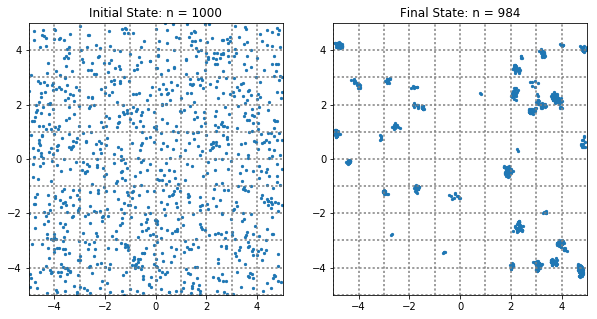

Simulation for Grid Size 10 x 10 - Reflective Boundary:


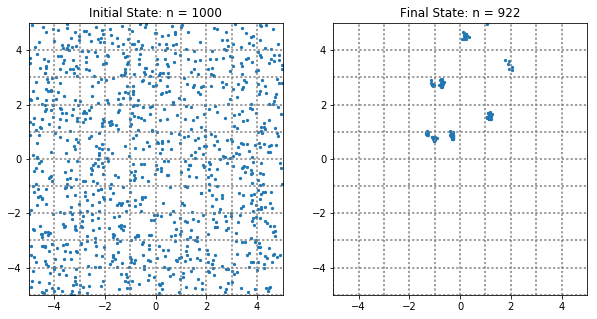

Simulation for Grid Size 20 x 20 - Periodic Boundary:


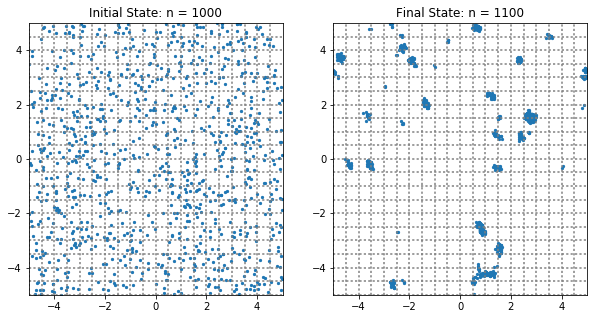

Simulation for Grid Size 20 x 20 - Reflective Boundary:


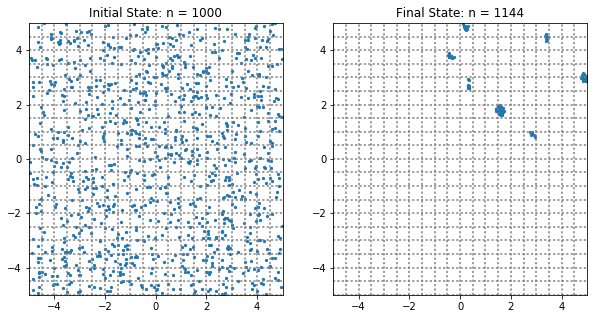

Simulation for Grid Size 30 x 30 - Periodic Boundary:


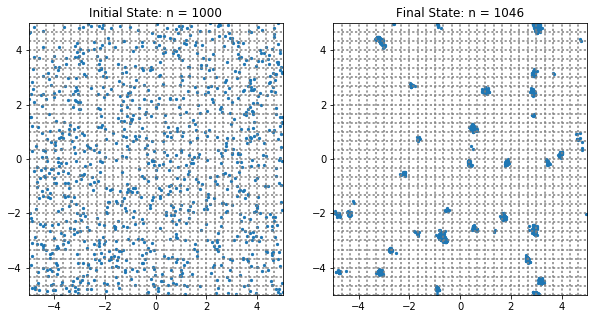

Simulation for Grid Size 30 x 30 - Reflective Boundary:


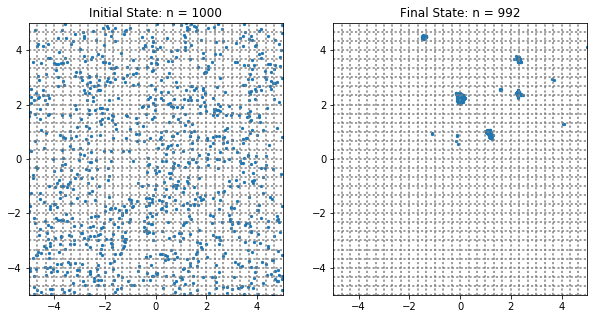

In [11]:
# run simulation, calculating densities at each timestep
nsteps = 1000
nns = [10, 20, 30]
bnds = [(1, 'Periodic'), (2, 'Reflective')]
densities_ta = []
for nn in nns:
    for bnd in bnds:
        b = bbm(nsteps = nsteps, itally = 1, nn = nn, bnd = bnd[0])
        print('Simulation for Grid Size %d x %d - %s Boundary:' % (nn, nn, bnd[1]))
        density = b.run(plot = True)
        densities_ta.append(density)

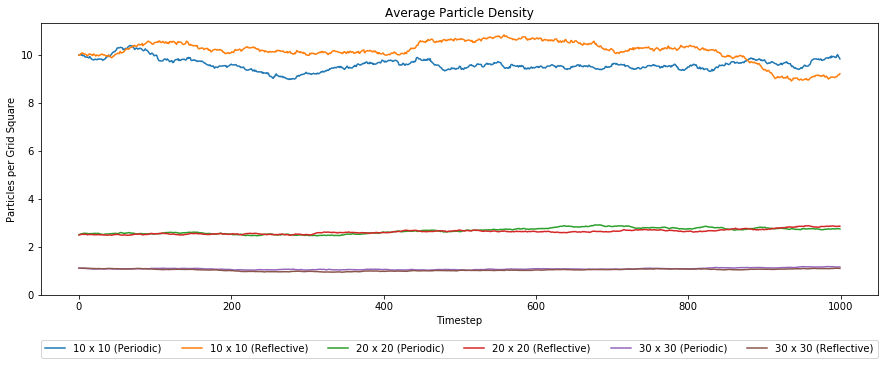

In [12]:
# plot densities by timestep
c = 0
for nn in nns:
    for bnd in bnds:    
        plt.plot(densities_ta[c], label = '%d x %d (%s)' % (nn, nn, bnd[1]))
        c+= 1
    
plt.ylim(ymin = 0)
plt.title('Average Particle Density')
plt.xlabel('Timestep')
plt.ylabel('Particles per Grid Square')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = c)

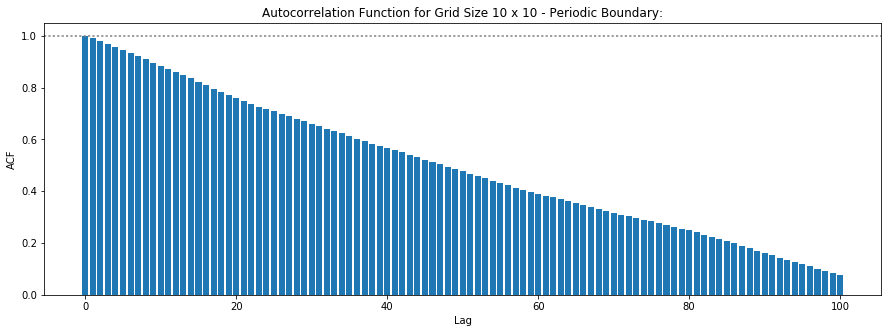

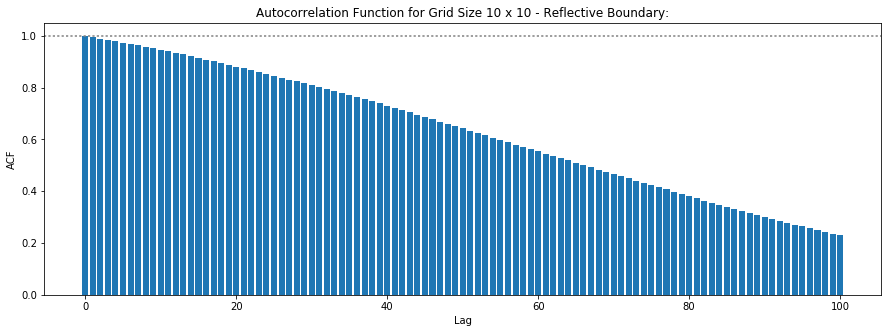

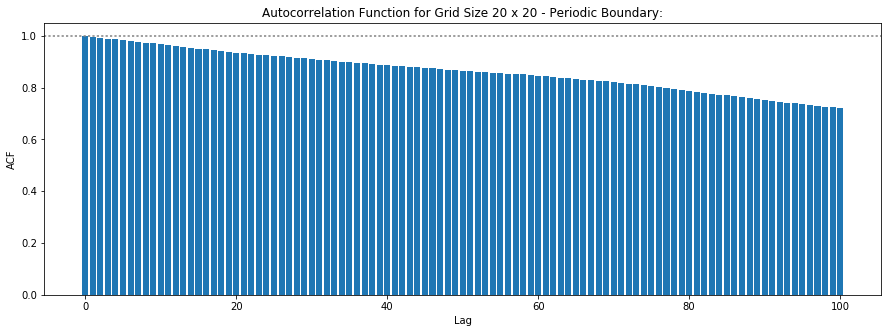

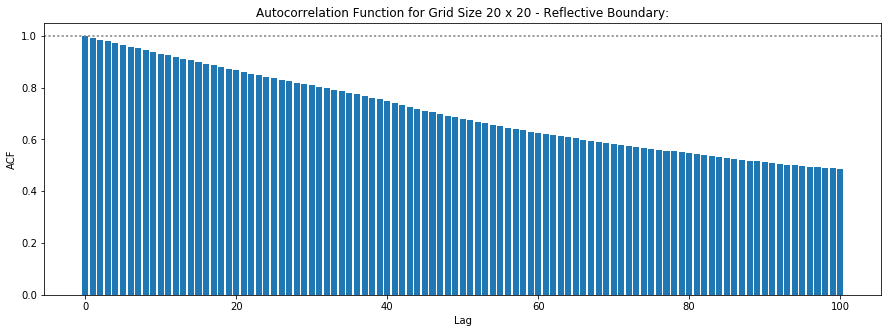

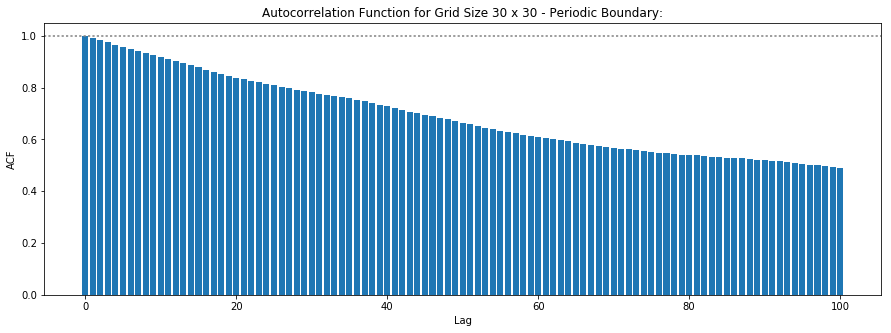

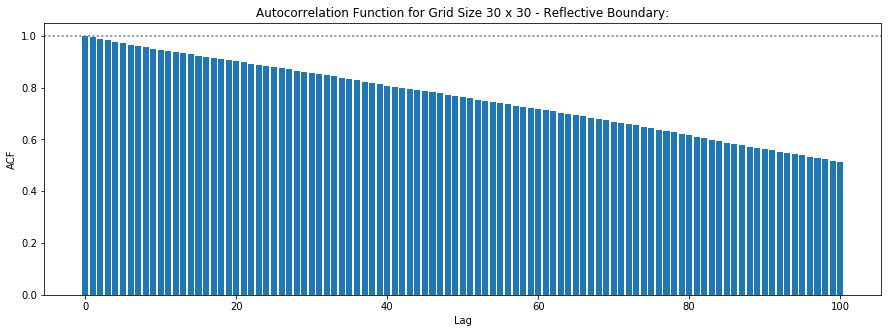

In [13]:
# plot autocorrelation
def plot_acf(density, nn, bnd, nlags = len(density)):
    acf = stattools.acf(density, nlags = nlags)
    lags = range(len(acf))
    plt.bar(lags, acf)
    plt.axhline(y = 1, ls = ':', c = 'gray')
    
    plt.title('Autocorrelation Function for Grid Size %d x %d - %s Boundary:' % (nn, nn, bnd))
    plt.ylabel('ACF')
    plt.xlabel('Lag')
    plt.show()

nlags = 100
c = 0
for nn in nns:
    for bnd in bnds:    
        plot_acf(densities_ta[c], nn, bnd[1], nlags)
        c+= 1

Similar analysis can be performed using ensembles, rather than timesteps, to calculate means.

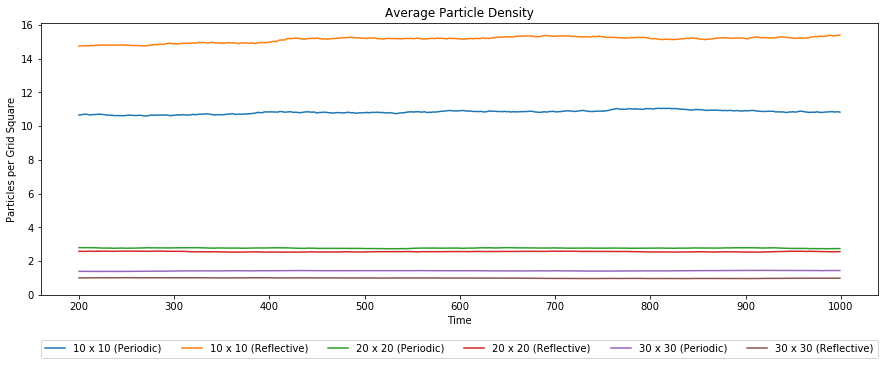

In [14]:
# run simulation, using ensembles to calculate densities
m = 10
burn_in = 200
densities_e = []
for nn in nns:
    for bnd in bnds:
        b = bbm(nsteps = nsteps, itally = 1, nn = nn, bnd = bnd[0])
        density = []
        for i in range(m):
            density.append(b.run())
            avg_density = np.mean(np.concatenate(density, axis = 1), axis = 1)
            avg_density[:burn_in] = np.nan
        plt.plot(avg_density, label = '%d x %d (%s)' % (nn, nn, bnd[1]))
        densities_e.append(avg_density)
        
    
plt.ylim(ymin = 0)
plt.title('Average Particle Density')
plt.xlabel('Time')
plt.ylabel('Particles per Grid Square')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = c)

It would appear both the time averaged and ensemble method to calculate particle density return fairly similar estimates; this suggests the process is stationary. Additionally, comparing the graphs of particle density over time, it would appear using an ensemble is more stable, converging slightly faster than time averaging.

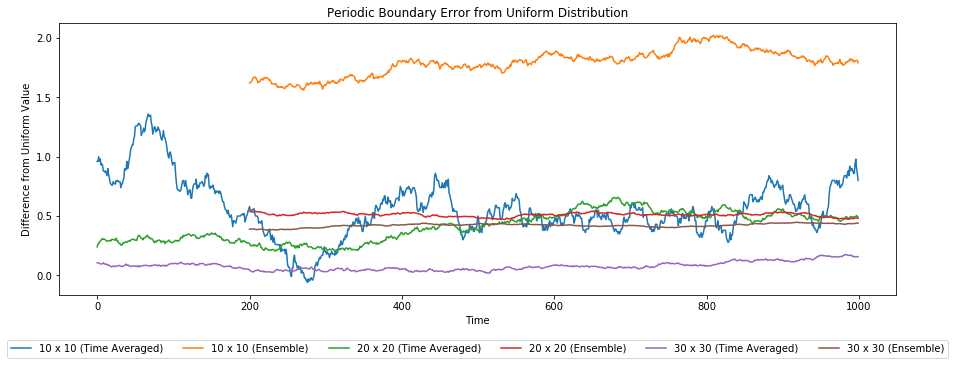

In [15]:
# compare periodic performance to the uniform distribution
c = 0
for nn in nns:
    for bnd in bnds:
        if bnd[0] == 1:
            u_value = b.n / nn ** 2
            error_ta = densities_ta[c] - u_value
            error_e = densities_e[c] - u_value
            plt.plot(error_ta, label = '%d x %d (Time Averaged)' % (nn, nn))
            plt.plot(error_e, label = '%d x %d (Ensemble)' % (nn, nn))
        c+= 1

plt.title('Periodic Boundary Error from Uniform Distribution')
plt.xlabel('Time')
plt.ylabel('Difference from Uniform Value')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = c)

Although the smaller grid size samples appear to have slightly larger errors, with overall more variance, it would seem the periodic results generally follow a uniform distribution. This is true for both the time averaged and ensemble calculation methods.

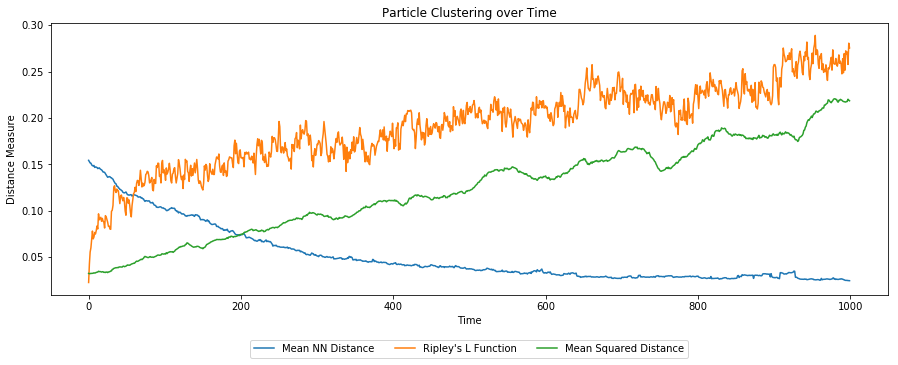

In [16]:
# quantify degree of particle clustering by time 
b = bbm(nsteps = nsteps, itally = 1)
r, L, err = b.run(clustering = True)

plt.plot(r, label = 'Mean NN Distance')
plt.plot(L, label = 'Ripley\'s L Function')
plt.plot(err, label = 'Mean Squared Distance')

plt.title('Particle Clustering over Time')
plt.xlabel('Time')
plt.ylabel('Distance Measure')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = c)